In [4]:
%pip install transformers evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.1 MB/s eta 0:00:00a 0:00:010m
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
from tqdm import tqdm

data = pd.read_csv("/kaggle/input/sentiment-analysis-for-financial-news/all-data.csv", encoding='latin-1', header=None)
data.columns = ["labels", "text"]
data

,labels,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [6]:
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

accuracy = evaluate.load("accuracy")

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
model = AutoModelForSequenceClassification.from_pretrained(
    "FacebookAI/roberta-base", num_labels=3, # id2label=id2label, label2id=label2id
)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):  
    return tokenizer(examples, truncation=True)  

texts = data["text"].to_list()
labels = data["labels"].to_list()
text_train, text_test, labels_train, labels_test = train_test_split(  
    texts, labels, test_size=0.25, random_state=42,   
)  
tokenized_text_train = preprocess_function(text_train)
tokenized_text_test = preprocess_function(text_test)

print("train size:", len(labels_train))
print("test size:", len(labels_test))


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

id2label = {0: "positive", 1: "neutral", 2: "negative"}
label2id = {"positive": 0, "neutral": 1, "negative": 2}

class BertDataset(torch.utils.data.Dataset):  
    def __init__(self, encodings, labels, label2id):  
        self.encodings = encodings  
        self.labels = [label2id[value] for value in labels]  
  
    def __getitem__(self, idx):  
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}  
        item['labels'] = torch.tensor(self.labels[idx])  
        return item  
  
    def __len__(self):  
        return len(self.labels)  

train_dataset = BertDataset(tokenized_text_train, labels_train, label2id)
test_dataset = BertDataset(tokenized_text_test, labels_test, label2id)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


train size: 3634
test size: 1212


In [7]:
training_args = TrainingArguments(
    output_dir="model_finetune",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none",
    logging_steps=1
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()
model = trainer.model

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.349700,0.374674,0.842409
2,0.474500,0.357618,0.855611
3,0.227300,0.417880,0.858086
4,0.310300,0.431845,0.864686
5,0.049400,0.679622,0.838284
6,0.004800,0.652019,0.866337
7,0.001300,0.753120,0.864686
8,0.001300,0.748697,0.867987
9,0.000800,0.793987,0.872112
10,0.000800,0.814653,0.868812


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

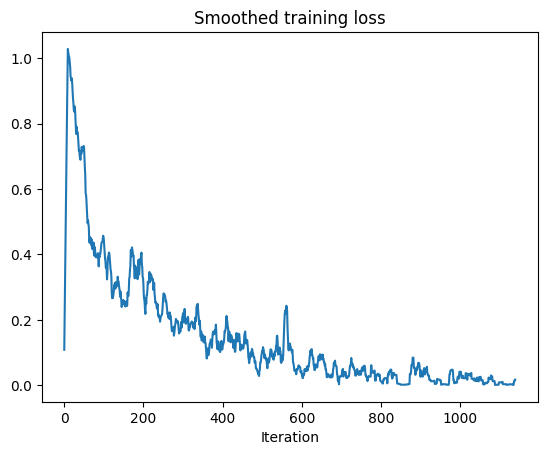

In [33]:
# Plot training loss graph
import matplotlib.pyplot as plt

training_loss = []
for x in trainer.state.log_history:
    if 'loss' in x.keys():
        training_loss.append(x['loss'])
        
def moving_average(data, window_size):
    cumsum = np.cumsum(np.insert(data, 0, np.zeros(window_size-1)))
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

plt.title("Smoothed training loss")
plt.xlabel("Iteration")
plt.plot(moving_average(training_loss, 10))

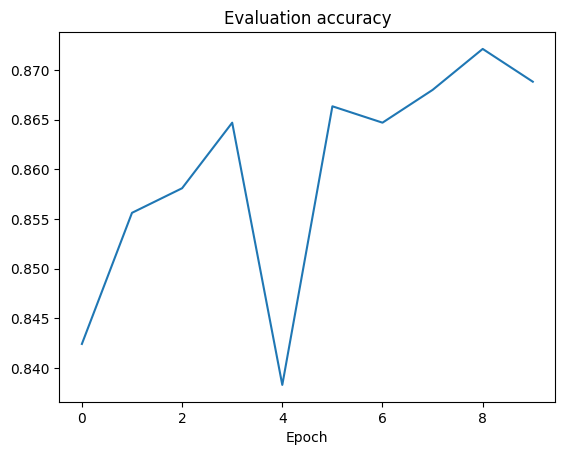

In [40]:
trainer.state.log_history
eval_accuracy = []
for x in trainer.state.log_history:
    if 'eval_accuracy' in x.keys():
        eval_accuracy.append(x['eval_accuracy'])
plt.title("Evaluation accuracy")
plt.xlabel("Epoch")
plt.plot(eval_accuracy)

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_preds = []
for text in tqdm(text_train):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    logits = model(**inputs) 
    predicted_class_id = logits.logits.argmax().item()
    train_preds.append(id2label[predicted_class_id])
    
test_preds = []
for text in tqdm(text_test):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    logits = model(**inputs) 
    predicted_class_id = logits.logits.argmax().item()
    test_preds.append(id2label[predicted_class_id])

100%|██████████| 1212/1212 [00:15<00:00, 78.14it/s]


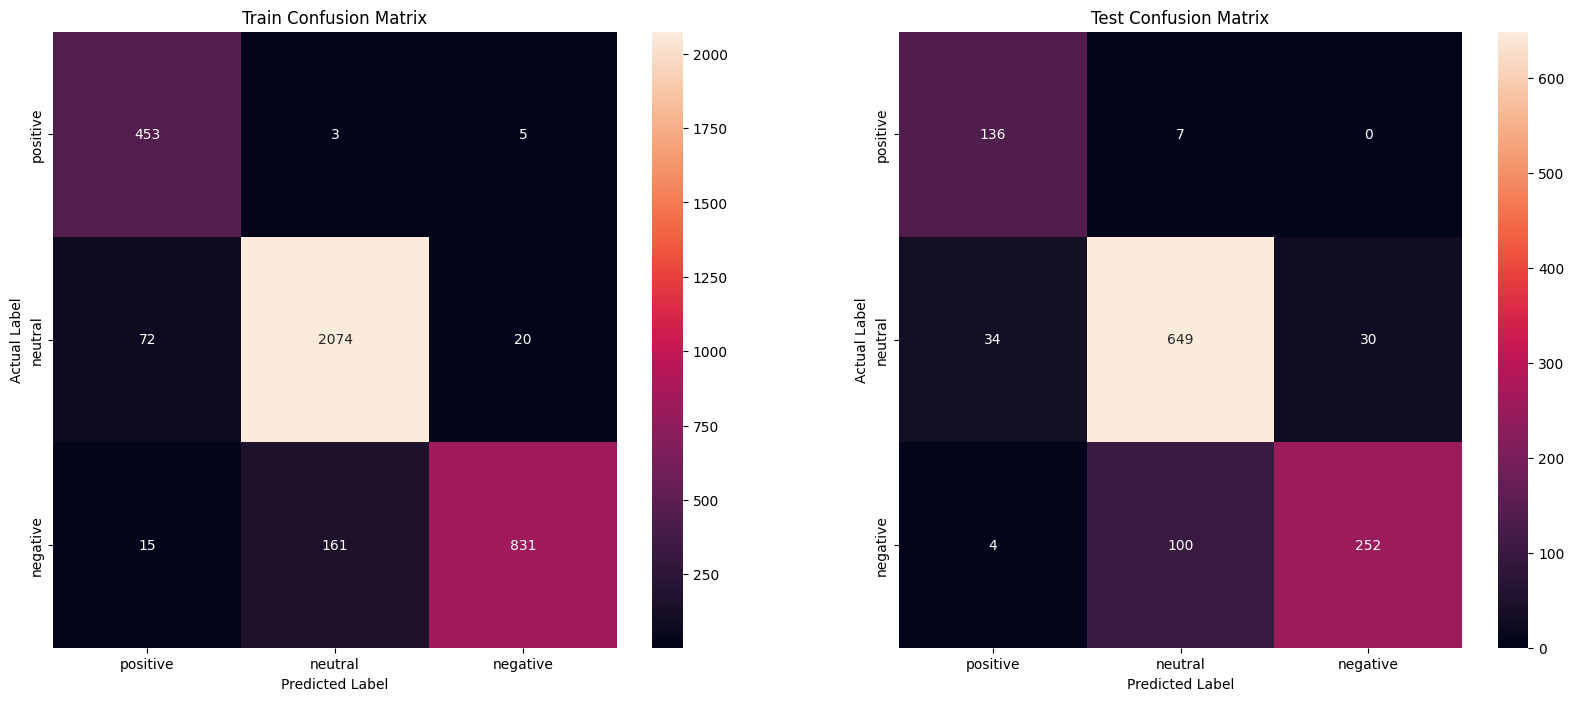

In [39]:
import seaborn as sns  
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix  
   
train_conf_mat = confusion_matrix(labels_train, train_preds)  
test_conf_mat = confusion_matrix(labels_test, test_preds)  
  
labels = list(label2id.keys())  
   
fig, ax = plt.subplots(1, 2, figsize=(20, 8))  
  
sns.heatmap(train_conf_mat, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, ax=ax[0])  
ax[0].set_title("Train Confusion Matrix")  
ax[0].set_ylabel("Actual Label")  
ax[0].set_xlabel("Predicted Label")  
   
sns.heatmap(test_conf_mat, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, ax=ax[1])  
ax[1].set_title("Test Confusion Matrix")  
ax[1].set_ylabel("Actual Label")  
ax[1].set_xlabel("Predicted Label")  
  
plt.show()  


In [42]:
from sklearn.metrics import classification_report  

train_report = classification_report(labels_train, train_preds, target_names=labels, digits=3)  
test_report = classification_report(labels_test, test_preds, target_names=labels, digits=3)  
  
print("Train Classification Report: ")  
print(train_report)  
  
print("\nTest Classification Report: ")  
print(test_report)  

Train Classification Report: 
              precision    recall  f1-score   support

    positive      0.839     0.983     0.905       461
     neutral      0.927     0.958     0.942      2166
    negative      0.971     0.825     0.892      1007

    accuracy                          0.924      3634
   macro avg      0.912     0.922     0.913      3634
weighted avg      0.928     0.924     0.923      3634


Test Classification Report: 
              precision    recall  f1-score   support

    positive      0.782     0.951     0.858       143
     neutral      0.858     0.910     0.884       713
    negative      0.894     0.708     0.790       356

    accuracy                          0.856      1212
   macro avg      0.845     0.856     0.844      1212
weighted avg      0.860     0.856     0.853      1212

